In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf # version 2.7.0

In [5]:
import tensorflow_probability as tfp # version 0.15.0

In [6]:
import scipy as scp
from matplotlib import cm

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve

from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

In [7]:
from mpl_toolkits import mplot3d

In [81]:
from scipy.linalg import solve

In [27]:
import scipy.stats as stats
import matplotlib.pyplot as plt
from __future__ import print_function
from mpl_toolkits import mplot3d
from matplotlib import cm
import time
from scipy.stats import norm as nm
from scipy.linalg import norm
from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

In [137]:
import timeit

# Original code

# Black Scholes using Normal distribution from Tensorflow

In [94]:
#Formula Variables / Parameters chosen
stock_price = 20.
strike_price = 10.
time_to_expire = 0.25
implied_volitility = 0.4
risk_free_rate_of_return = 0.02
seed = 122 #randomly selected

r = 0.1
sigma = 0.2
S_0 = 100
X_0 = np.log(50)
K = 100
T_end = 1

In [50]:
# True Solution
def BlkSos(r, S, K, T, sigma, type = "Call"):
    "Calculate True BlkSos"
    d1 = (np.log(S/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if type == "Call":
        Price = S * nm.cdf(d1, 0, 1) - K * np.exp(-r * T) * nm.cdf(d2, 0, 1)

    elif type == "Put":
        Price = K * np.exp(-r * T) * nm.cdf(-d2, 0, 1) - S * nm.cdf(-d1, 0, 1)

    return Price

# Monte Carlo

In [58]:
#Path Simulator Graph - setup code

def black_scholes_formula(stockPrice, strike, time_to_expr, imp_vol, risk_free, timedelta, stdnorm_random_variates):
    return stockPrice * tf.math.cumprod(tf.exp((risk_free - 0.5 * imp_vol ** 2) * timedelta + imp_vol * tf.sqrt(timedelta) * stdnorm_random_variates), axis = 1)

def make_path_simulator(stockPrice, strike, time_to_expr, imp_vol, risk_free, seed, n_sims, obs):
    #Create the time variables
    if seed != 0:
        np.random.seed(seed)
    stdnorm_random_variates = np.random.randn(n_sims, obs)
    timedelta = time_to_expr / stdnorm_random_variates.shape[1]
    return black_scholes_formula(stockPrice, strike, 
                                 time_to_expr, imp_vol, risk_free, timedelta, stdnorm_random_variates)

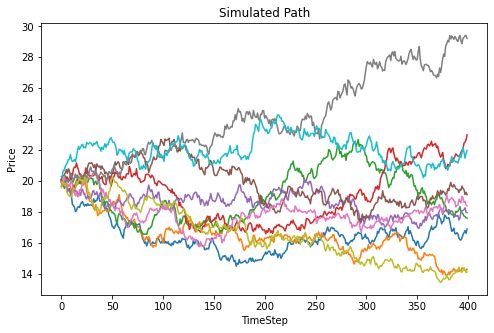

In [59]:
#Path Simulator Graph - graphing code
path_simulator = tf.function(make_path_simulator)
paths = path_simulator(stock_price,strike_price,
                       time_to_expire,implied_volitility,risk_free_rate_of_return, seed, 10, 400)
plt.figure(figsize=(8,5))
_ = plt.plot(np.transpose(paths))
_ = plt.title('Simulated Path')
_ = plt.ylabel('Price')
_ = plt.xlabel('TimeStep')
plt.show()

In [142]:
def create_montecarlo_tf_pricer(stockPrice, strike, time_to_expr, imp_vol, risk_free, seed, n_sims, obs):
    if seed != 0:
        np.random.seed(seed)
    
    stdnorm_random_variates = np.random.randn(n_sims, 1)
    time_del = time_to_expr / stdnorm_random_variates.shape[1]
    
    S_T = black_scholes_formula(stockPrice, strike, time_to_expr, imp_vol, risk_free, time_del, stdnorm_random_variates)
    payout = tf.maximum(S_T[:,-1] - strike, 0)
    npv = tf.exp(-risk_free*time_to_expr) * tf.reduce_mean(payout)
    target_calc = npv
    return target_calc

In [143]:
sims = 1000
observations = 10

montecarlo_tf_pricer = tf.function(create_montecarlo_tf_pricer)

In [115]:
montecarlo_tf_pricer(stock_price,strike_price,time_to_expire,implied_volitility,risk_free_rate_of_return, 302, sims,observations).numpy()

10.046899

## Crank-Nicholson

In [74]:
def LHS_matrix(M, alpha, beta, gamma):
    """generate and return the LHS coefficient matrix A.
    
    Arguments:
        M:       total number of spatials grids
        alpha:   array of coefficients on lower diagnoal
        beta:    array of coefficients on diagnoal
        gamma:   array of coefficients on upper diagnoal
    
    Returns:
        A:       LHS coefficient matrix
    """
    # diagonal
    d = np.diag(1+beta)
    # upper diagonal
    ud = np.diag(gamma[:-1], 1)
    # lower diagonal
    ld = np.diag(alpha[1:], -1)
    
    A = d +ud +ld
    return A

In [75]:
def RHS(C, alpha, beta, gamma, S_max, E):
    """generate and return the RHS vector b.
    
    Arguments:
        C:       array of the price of call option at previous time step
        alpha:   array of coefficients on lower diagnoal
        beta:    array of coefficients on diagnoal
        gamma:   array of coefficients on upper diagnoal
        S_max:   upper bound of stock price
        E:       exercise price
    
    Returns:
        b:       RHS vector
    """
    # diagonal of A_star
    d = np.diag(1-beta)
    # upper diagonal of A_star
    ud = np.diag(-gamma[:-1], 1)
    # lower diagonal of A_star
    ld = np.diag(-alpha[1:], -1)
    
    A_star = d + ud + ld
    b = np.dot(A_star,C[1:-1])
    # add BC for the right bound (the last element)
    b[-1] += -2*gamma[-1] * (S_max-E) 
    
    return b

In [76]:
def CrankNicolson(C, A, N, alpha, beta, gamma, S_max, E):
    """using Crank-Nicolson scheme to solve the Black-Scholes equation for the call option price.
    
    Arguments:
        C:       array of the price of call option
        A:       LHS coefficient matrix
        N:       total number of time steps       
        alpha:   array of coefficients on lower diagnoal
        beta:    array of coefficients on diagnoal
        gamma:   array of coefficients on upper diagnoal
        S_max:   upper bound of stock price
        E:       exercise price
    
    Returns:
        C:       array of the price of call option
    """
    for t in range(N):
        b = RHS(C, alpha, beta, gamma, S_max, E)
        # use numpy.linalg.solve
        C[1:-1] = solve(A,b)
    return C

In [82]:
def CN_iterations(N, M, T, r, sigma, E):
    """
      T:                 expiry time
      r =                no-risk interest rate
      sigma =            volatility of underlying asset
      E                  exercise price (sometimes known as K)
             upper bound of price of the stock (4*E)
      N                  number of time steps 
      M                  number of space grids
    """
    S_max = 4*E 
    dt = T/N       # time step
    s = np.linspace(0, S_max, M+1)   # spatial grid (stock's price)

    # initial condition & boundary condition
    C = s - E
    C = np.clip(C, 0, S_max-E)

    N = 200        # number of time steps
    dt = T/N       # time step

    # initial condition & boundary condition
    C = s - E
    C = np.clip(C, 0, S_max-E)

    # calculating the coefficient arrays
    index = np.arange(1,M)

    alpha = dt/4 * (r*index - sigma**2*index**2)
    beta = dt/2 * (r + sigma**2*index**2)
    gamma = -dt/4 * (r*index + sigma**2*index**2)

    A = LHS_matrix(M, alpha, beta, gamma)
    C_imp = CrankNicolson(C, A, N, alpha, beta, gamma, S_max, E)
    
    return s, C_imp

In [109]:
s,C_imp = CN_iterations(N=200, M=200, T=0.25, r=0.1, sigma=0.0000001, E=10.)

/var/folders/bb/l238t8991n9cbw8l10c1k5980000gn/T/ipykernel_34000/1898497283.py:3: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


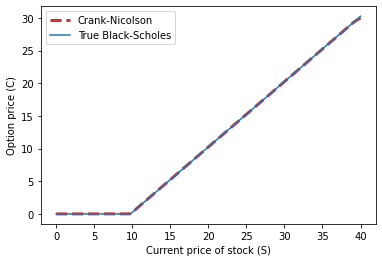

In [110]:
plt.plot(s,C_imp,color='#cd3333', ls='--', lw=3, label='Crank-Nicolson')
plt.plot(s, BlkSos(0.1, s, 10.,0.25, 0.0000001), label='True Black-Scholes')
plt.xlabel("Current price of stock (S)")
plt.ylabel("Option price (C)")
plt.legend()

In [111]:
s_2=s.tolist()

In [130]:
prices=[]
for s_i in s_2:
    x=montecarlo_tf_pricer(s_i,strike_price,time_to_expire,0.4,risk_free_rate_of_return, 302, sims,2000).numpy()
    prices.append(x)

/var/folders/bb/l238t8991n9cbw8l10c1k5980000gn/T/ipykernel_34000/1898497283.py:3: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))


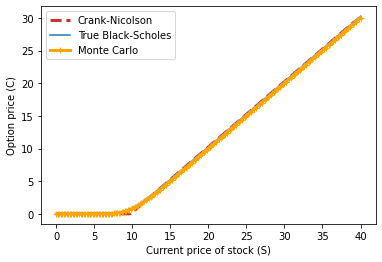

In [131]:
plt.plot(s,C_imp,color='#cd3333', ls='--', lw=3, label='Crank-Nicolson')
plt.plot(s, BlkSos(0.1, s, 10.,0.25, 0.4), label='True Black-Scholes')
plt.plot(s,prices,color='orange', marker='+', lw=3, label='Monte Carlo')
plt.xlabel("Current price of stock (S)")
plt.ylabel("Option price (C)")
plt.legend()

/var/folders/bb/l238t8991n9cbw8l10c1k5980000gn/T/ipykernel_34000/1898497283.py:3: RuntimeWarning: divide by zero encountered in log
  d1 = (np.log(S/K) + (r + sigma**2 / 2) * T) / (sigma * np.sqrt(T))
/var/folders/bb/l238t8991n9cbw8l10c1k5980000gn/T/ipykernel_34000/508440425.py:3: RuntimeWarning: invalid value encountered in true_divide
  error_MC=np.abs(prices-true)/true
/var/folders/bb/l238t8991n9cbw8l10c1k5980000gn/T/ipykernel_34000/508440425.py:4: RuntimeWarning: invalid value encountered in true_divide
  error_CN = np.abs((C_imp-true)/true)


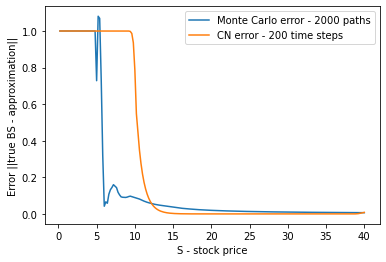

In [135]:
true=BlkSos(0.1, s, 10.,0.25, 0.4)

error_MC=np.abs(prices-true)/true
error_CN = np.abs((C_imp-true)/true)
plt.plot(s, error_MC, label='Monte Carlo error - 2000 paths')
plt.plot(s, error_CN, label='CN error - 200 time steps')
plt.xlabel("S - stock price")
plt.ylabel("Error ||true BS - approximation||")
plt.legend()

## When to use Monte Carlo vs Iterative Methods